In [1]:
%run base.ipynb
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as torchdata
import ignite.metrics as ignite_metrics

import utils

import iisignature
import sig_inversion

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Hyperparameters

In [2]:
max_epochs = 5000
optimizer_fn = lambda x: optim.Adam(x, lr=0.002)

## Data

In [3]:
paths = {
            "zero":  "29, 97,  0, 57, 22, 10, 68,  0,100, 40, 83, 90, 37,100, 12, 57",
            "three": "37, 80, 53,100, 88, 83, 59, 60,100, 44, 92, 15, 49,  0,  0,  8",
            "six":   "70,100, 54, 86, 29, 53, 23, 16, 69,  0,100, 23, 50, 36,  0, 21",
            "eight": "87, 67, 66,100,  0, 79, 49, 45,100, 10, 40,  0, 37, 40, 81, 78",
        }

In [4]:
from sklearn.preprocessing import MinMaxScaler

path = paths["three"]
path = np.array(path.split(","), dtype=float).reshape(-1, 2)
path = MinMaxScaler(feature_range=(-1, 1)).fit_transform(path)

In [5]:
order = 12
sig = iisignature.sig(path, order).reshape(1, -1)
n_steps = len(path)

dataloader = torchdata.DataLoader(torchdata.TensorDataset(torch.ones(1, 1, 1),
                                                          torch.tensor(sig, dtype=torch.float)))

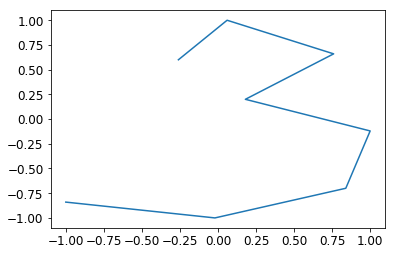

In [6]:
plt.plot(*path.T)
plt.show()

## Define Neural Network model

In [7]:
batch, output = next(iter(dataloader))

In [8]:
model = sig_inversion.Invert(n_steps, order, derivatives=False)

# We set the initial path to the constant path.
# This sometimes helps convergence.
model.path.weight = torch.nn.Parameter(data=torch.zeros_like(model.path.weight))

loss_fn = sig_inversion.loss_fn(order)

## Train Model

In [9]:
history = {}
train_model = utils.create_train_model_fn(max_epochs, optimizer_fn, loss_fn, dataloader, dataloader, 
                                          batch, metrics={"accuracy": ignite_metrics.MeanSquaredError()})

In [ ]:
train_model(model, 'SigNet', history, device="cpu")

## Results

In [11]:
def print_results(history):
    fig, axs = plt.subplots(1, 2, gridspec_kw={'wspace': 0.6, 'hspace': 0.6}, figsize=(12, 4))
    axs = axs.flatten()
    for i, metric_name in enumerate(('train_loss', 'val_loss')):
        ax = axs[i]
        for model in history:
            metric = history[model][metric_name]
            
            ax.plot(metric, 'r-', lw=1)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric_name)

    plt.show()

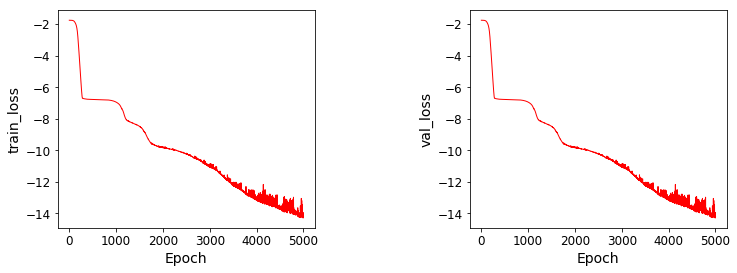

In [12]:
print_results(history)

In [13]:
generated_path = model.get_path()
generated_path += path[0] - generated_path[0]

generated_path = sig_inversion.get_tree_reduced(generated_path, tol=0.1)

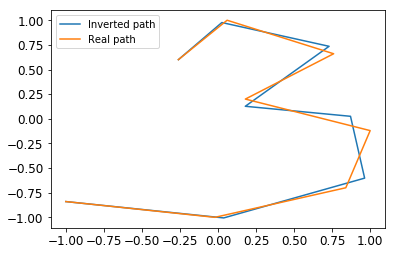

In [14]:
plt.plot(*generated_path.T, label="Inverted path")
plt.plot(*path.T, label="Real path")
plt.legend()
plt.show()

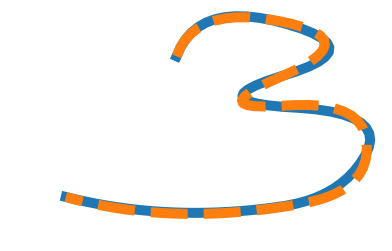

In [15]:
import importlib
importlib.reload(sig_inversion)
sig_inversion.plot(path, label="Original path", linewidth=10, linestyle="-")
sig_inversion.plot(generated_path, label="Generated path", linewidth=10, linestyle="--")
plt.axis('off')
plt.show()